In [ ]:
#!/usr/bin/env python3
# coding=utf-8

import time
import numpy as np
import cv2
import torch
import pyrealsense2 as rs
import ikpy.chain
from matplotlib import pyplot as plt

# 机械臂控制相关
from Arm_Lib import Arm_Device

# YOLO 相关
from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import (
    check_img_size, non_max_suppression, scale_coords, xywh2xyxy, plot_one_box
)
from utils.torch_utils import select_device, time_synchronized


# 机械臂参数
SERVO_SPEED = 6
LINK_LIST = [0, 30, 83, 83, 80, 90]
TOMATO_SIZE = (0.033, 0.037)  # 单位：米
GRABBER = {'open': 80, 'close': 160}
DROP_POSITION = [-0.05, -0.2, 0.15]


def read_servolines(Arm):
    """读取机械臂当前关节角度。"""
    angles = [Arm.Arm_serial_servo_read(i + 1) or 0 for i in range(6)]
    time.sleep(0.02)
    return angles
    

def calculate_servotime(arm, target, speed=SERVO_SPEED):
    """计算机械臂移动所需时间。"""
    current_positions = np.array(read_servolines(arm))
    return int(np.sum(np.abs(current_positions - np.array(target))) * speed)

def servo_write(arm, target_angles, speed, duration=None):
    """控制机械臂关节移动到指定角度。"""
    move_time = calculate_servotime(arm, target_angles, speed) if duration is None else duration
    arm.Arm_serial_servo_write6(*target_angles, move_time)
    time.sleep(move_time / 1000)
    return move_time


def one_step(model,pipeline,align,names,img_save=True):
    
    frames = pipeline.wait_for_frames()
    aligned_frames = align.process(frames)
    aligned_depth_frame = aligned_frames.get_depth_frame()
    color_frame = aligned_frames.get_color_frame()
    # 将帧转换为numpy数组
    color_image = np.asanyarray(color_frame.get_data())
    color_image = cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR)
    depth_intrinsics = aligned_depth_frame.profile.as_video_stream_profile().intrinsics
    device = select_device('')
    # path, img, im0s, vid_cap = LoadStreams(source, img_size=320)
    
    img = torch.tensor(color_image)
    img = np.transpose(img, (2, 0, 1))
    half = device.type != 'cpu'  # half precision only supported on CUDA
    img = img.half() if half else img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)
    
    img = img.to(device)
    t1 = time_synchronized()
    pred = model(img, augment=True)[0]

    # Apply NMS
    pred = non_max_suppression(pred, 0.8, 0.3, classes=None, agnostic=True)
    t2 = time_synchronized()

    # Process detections
    img = np.array(img.squeeze(0).cpu())
    img = np.transpose(img, (1, 2, 0))
    img = img * 255
    img = img.astype(np.uint8)
    for i, det in enumerate(pred):  # detections per image
        # Print time (inference + NMS)
        print('Done. ({:.3f}s)'.format((t2 - t1)))    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if det is not None:
        for *xyxy, conf, cls in reversed(det):
            label = '%s %.2f' % (names[int(cls)], conf)
            print(xyxy)
            plot_one_box(xyxy, img, label=label, line_thickness=3)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.imshow(img)
    plt.show()
    if img_save:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cv2.imwrite("a.png",img)
    return det,aligned_depth_frame,depth_intrinsics



def camera_to_world(P_cam, T_cam, R_cam):
    """
    将相机坐标系下的点转换为世界坐标系。
    
    参数：
        P_cam (numpy.array): 相机坐标系下的点 (3x1)。
        T_cam (numpy.array): 相机在世界坐标系中的位置 (3x1)。
        R_cam (numpy.array): 相机的旋转矩阵 (3x3)。
    
    返回：
        numpy.array: 世界坐标系下的点 (3x1)。
    """
    P_world = R_cam @ P_cam + T_cam
    return P_world

def calculate_tomato_coor(det):
    res = []
    for i,(*xyxy, conf, cls) in enumerate(det):
        # 现在只抓番茄
        if cls == 2:
            x = int(xyxy[2]-xyxy[0])
            y = int(xyxy[3]-xyxy[1])
            c_x = int((xyxy[0]+ xyxy[2])/2)
            c_y = int((xyxy[1]+ xyxy[3])/2)
            res.append([i,c_x,c_y,x,y,conf,cls])
    return res

def select_tomato():
    # 根据坐标计算得分并选择番茄,现在是用得分最高的
    # 可以用最靠近一侧的番茄
    pass

def control_arm_coor(Arm,my_chain,target_position,grabber,rotation=90,compensate=2):
    converted_position = np.array(target_position)
    print("target coor:",converted_position)
    joints = my_chain.inverse_kinematics(converted_position,initial_position = np.radians([0,90,120,30,40,90,30]))
    joint_list = joints[1:-2]
    print("servos should be",np.degrees(joint_list))
    joint_deg_list = [int(x)for x in np.degrees(joint_list)]
    joint_deg_list.append(rotation)
    joint_deg_list.append(grabber)
    print("The angles of each joints should be:" , joint_deg_list)
    real_frame = my_chain.forward_kinematics(joints)
    error = np.abs(np.linalg.norm(list(real_frame[:3,3]),ord=2)-np.linalg.norm(converted_position,ord=2))
    print("Error:{:.2f}%".format(error*100))
    print("The position is:\n", real_frame)
    if "{:.2f}%".format(error*0.05) != "0.00%":
        print("out of range")
    else:
        print(joint_deg_list)
        if compensate & all([(x - compensate) < 179 for x in joint_deg_list[1:4]]):
            
            joint_deg_list[1:4] = [(x+compensate) for x in joint_deg_list[1:4]]
            print(f"final joint:{joint_deg_list}")
        return servo_write(Arm,joint_deg_list,SERVO_SPEED),joint_deg_list


def object_axis_angle(xyxy,depth_image, padding=5):
    obj_depth_image = depth_image[(xyxy[1]-padding):(xyxy[3]+padding),(xyxy[0]-padding):(xyxy[2]+padding)]
    hist, bin_edges = np.histogram(obj_depth_image,120,range=(100,600))

    min_val = bin_edges[np.argmax(hist)-2]
    max_val = bin_edges[np.argmax(hist)+2]

    mask = (obj_depth_image > min_val) & (obj_depth_image < max_val)
    # 找到 mask 中为 True 的坐标
    y_coords, x_coords = np.where(mask)
    points = np.column_stack((x_coords, y_coords))  # 转换为点集

    # 计算旋转最小包围矩形
    rect = cv2.minAreaRect(points.astype(np.float32))  # (center, (width, height), angle)

    # 提取矩形参数
    (center_x, center_y), (width, height), angle = rect

    # 短轴的倾斜角计算
    if width < height:
        short_axis_angle = (angle + 90)  # 宽是短轴，直接取 angle
    else:
        short_axis_angle = angle  # 高是短轴，角度加 90°
    print("short_axis_angle:",short_axis_angle)
    return short_axis_angle




def object_position(det,aligned_depth_frame,depth_intrinsics,T_cam,R_cam,tomato_halfsize=0.005,compen = True):
    res = calculate_tomato_coor(det)
    
    point_list = []
    depth_image = np.asanyarray(aligned_depth_frame.get_data())
    for obj in res:
        *xyxy, conf, cls = det[obj[0]]
        xyxy = [int(x) for x in xyxy]
        depth_value = aligned_depth_frame.get_distance(obj[1], obj[2]) + tomato_halfsize
        point = rs.rs2_deproject_pixel_to_point(depth_intrinsics, [obj[1], obj[2]], depth_value)
        axis_angle = object_axis_angle(xyxy,depth_image, padding=20)
        point = [-point[2],point[0],point[1],int(axis_angle)]
        point_list.append(point)
        print(f"Index:{obj[0]}, Pixel: ({obj[1]}, {obj[2]}) -> Point: {point}")
    
    point_list = np.array(point_list)
    

    
    
    
    try:
        filtered_point_list = point_list[point_list[:, 0] > -0.4]

        sorted_point_list = filtered_point_list[np.argsort(filtered_point_list[:, 0])][::-1]
        *P_cam,obj_axis_angle = sorted_point_list[0]
    except:
        return None,None

    # 将相机坐标系的点转换为世界坐标系
    P_world = camera_to_world(P_cam, T_cam, R_cam)
    print("Position of the most confident object to be tomato :", np.array(P_world))
    if compen:
        z = P_world[2]
        z = z + (0.35-z)*0.15
        P_world[2] = z
    return np.array(P_world),obj_axis_angle


def camera_position(Arm,my_chain):
    servos = read_servolines(Arm)
    servos = np.radians([0,servos[0],servos[1],servos[2],servos[3],servos[4],servos[5]])
    transformations = my_chain.forward_kinematics(servos, full_kinematics=True)
    servo4_transform = transformations[4]
    
    print(f"关节 {4} 的变换: {servo4_transform},\n坐标:{servo4_transform[:3,3]}")

    camera_offset_z_rotated = np.array([
    [0,  0, -1, 0.04],
    [1,  0,  0, -0.06],
    [0, 1,  0, -0.03],
    [0, 0, 0, 1]
    ])
    camera_transform = np.dot(servo4_transform, camera_offset_z_rotated)
    camera_position = camera_transform[:3, 3]
    camera_rotation = camera_transform[:3, :3]
    print("摄像头的位置（相对于世界坐标系）：", camera_position)
    return camera_position,camera_rotation


待解决事项（优先度）：

    1. 只抓能抓到的

        a. 通过番茄距离估计该串番茄大概位置范围

        b. 通过检测到的stem计算主干位置

        c. 通过深度图估计番茄是否被遮挡---最可能实现

            提取深度图

    2. 旋转夹子从番茄短轴接近（准备在论文中添加）

        a. 直接在神经网络中标注直接预测

        b. 通过深度图的梯度计算
        
    3. 论文中使用单目估计作为baseline，确认方法的提升
    

In [31]:

my_chain = ikpy.chain.Chain.from_urdf_file("/home/jetson/code/yolov5/yolov5-3.0/arm_real copy.URDF",active_links_mask=[False,True,True,True,True,True,False])
Arm = Arm_Device()


In [32]:
Arm.Arm_serial_set_torque(1)
servo_write(Arm,[90,90,90,90,90,0],SERVO_SPEED,1500)
# object_position(det,aligned_depth_frame,depth_intrinsics)
camera_position(Arm,my_chain)

关节 4 的变换: [[    0.99802   -0.034852    0.052336   0.0099076]
 [  -0.052304   0.0018228     0.99863 -0.00051325]
 [  -0.034899    -0.99939 -3.6732e-06      0.2729]
 [          0           0           0           1]],
坐标:[  0.0099076 -0.00051325      0.2729]
摄像头的位置（相对于世界坐标系）： [   0.050349   -0.032674     0.33146]


(array([   0.050349,   -0.032674,     0.33146]),
 array([[  -0.034852,    0.052336,    -0.99802],
        [  0.0018228,     0.99863,    0.052304],
        [   -0.99939, -3.6732e-06,    0.034899]]))

In [33]:
# 初始化RealSense管道
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)

# 启动管道
pipeline.start(config)
align_to = rs.stream.color
align = rs.align(align_to)

In [34]:
control_arm_coor(Arm,my_chain,[-0.05,0.05,0.23],GRABBER['open'])

target coor: [      -0.05        0.05        0.23]
servos should be [         45       171.6      17.984     0.20211]
The angles of each joints should be: [45, 171, 17, 0, 90, 80]
Error:0.00%
The position is:
 [[     0.7071    -0.12018    -0.69682   -0.050012]
 [    0.70711     0.12018     0.69681    0.050012]
 [-3.0489e-06    -0.98545     0.16996     0.23001]
 [          0           0           0           1]]
[45, 171, 17, 0, 90, 80]


(2184, [45, 171, 17, 0, 90, 80])

In [35]:
# target = [135, 96, 29, 22, 90, 150]
# servo_write(Arm,target,SERVO_SPEED)
model = attempt_load('/home/jetson/code/yolov5/yolov5-3.0/0214.pt', map_location=select_device('')).half()  # load FP32 model
# Run inference
img = torch.zeros((1, 3, 640, 640), device=select_device(''))  # init img
_ = model(img.half())
names = ['leaf','stem','tomato',]


Fusing layers... 


target coor: [      -0.05        0.05        0.28]
servos should be [         45      155.83      33.102      10.695]
The angles of each joints should be: [45, 155, 33, 10, 90, 80]
Error:0.00%
The position is:
 [[     0.7071    -0.23755    -0.66601       -0.05]
 [    0.70711     0.23755     0.66601        0.05]
 [-2.4392e-06    -0.94188     0.33595        0.28]
 [          0           0           0           1]]
[45, 155, 33, 10, 90, 80]
Done. (1.423s)
[tensor(362.06250, device='cuda:0', grad_fn=<SelectBackward>), tensor(358.09375, device='cuda:0', grad_fn=<SelectBackward>), tensor(458.43750, device='cuda:0', grad_fn=<SelectBackward>), tensor(476.40625, device='cuda:0', grad_fn=<SelectBackward>)]


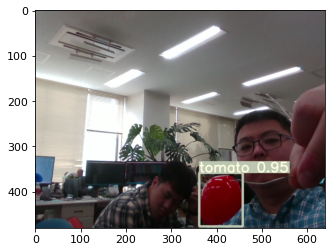

关节 4 的变换: [[    0.22616     0.65681     0.71934    0.062978]
 [   -0.23419    -0.68015     0.69466   -0.065068]
 [    0.94552    -0.32557 -3.6732e-06     0.22157]
 [          0           0           0           1]],
坐标:[   0.062978   -0.065068     0.22157]
摄像头的位置（相对于世界坐标系）： [   0.011036   -0.054466     0.27893]
Done. (0.428s)
[tensor(372.84375, device='cuda:0', grad_fn=<SelectBackward>), tensor(314.34375, device='cuda:0', grad_fn=<SelectBackward>), tensor(476.15625, device='cuda:0', grad_fn=<SelectBackward>), tensor(429.15625, device='cuda:0', grad_fn=<SelectBackward>)]


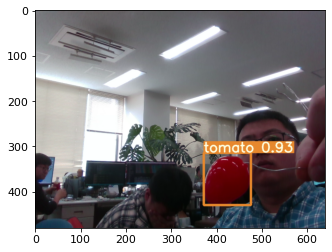

Task on [-0.05, 0.05, 0.28] is finished
target coor: [      -0.05        0.05        0.23]
servos should be [         45       171.6      17.984     0.20211]
The angles of each joints should be: [45, 171, 17, 0, 90, 80]
Error:0.00%
The position is:
 [[     0.7071    -0.12018    -0.69682   -0.050012]
 [    0.70711     0.12018     0.69681    0.050012]
 [-3.0489e-06    -0.98545     0.16996     0.23001]
 [          0           0           0           1]]
[45, 171, 17, 0, 90, 80]
Done. (0.541s)


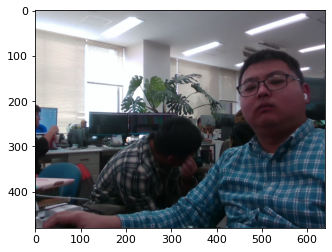

Task on [-0.05, 0.05, 0.23] is finished
target coor: [      -0.05        0.05        0.17]
servos should be [         45      171.89     0.38204  1.2221e-11]
The angles of each joints should be: [44, 171, 0, 0, 90, 80]
Error:1.88%
The position is:
 [[    0.70711    0.095114    -0.70068   -0.068234]
 [    0.70711    -0.09512     0.70068    0.068234]
 [-4.1673e-06    -0.99091    -0.13452     0.17856]
 [          0           0           0           1]]
[44, 171, 0, 0, 90, 80]


KeyboardInterrupt: 

: 

In [ ]:

task_list = [[-0.05,0.05,0.28],[-0.05,0.05,0.23],[-0.05,0.05,0.17]] # !!!!!!modify here to set the origin position
while task_list:
    target = task_list[0]
    s_time,target_joint_degree_list = control_arm_coor(Arm,my_chain,target,GRABBER['open'])
    time.sleep(1)
    flag = True

    det,aligned_depth_frame,depth_intrinsics = one_step(model,pipeline,align,names)

    while det is not None and flag :
        flag = False
        T_cam,R_cam = camera_position(Arm,my_chain)
        position_tomato,rotation = object_position(det,aligned_depth_frame,depth_intrinsics,T_cam,R_cam)
        if position_tomato is not None:
            print(position_tomato)
            if control_arm_coor(Arm,my_chain,position_tomato,GRABBER['open'],rotation):
                control_arm_coor(Arm,my_chain,position_tomato,GRABBER['close'],rotation)
                control_arm_coor(Arm,my_chain,target,GRABBER['close'])
                control_arm_coor(Arm,my_chain,DROP_POSITION,GRABBER['close'])
                control_arm_coor(Arm,my_chain,DROP_POSITION,GRABBER['open'])
                control_arm_coor(Arm,my_chain,target,GRABBER['open'])
                flag = True
        time.sleep(1)
        det,aligned_depth_frame,depth_intrinsics = one_step(model,pipeline,align,names)



    print(f"Task on {task_list.pop(0)} is finished")



# Below for debug

Done. (0.521s)
[tensor(413.12500, device='cuda:0', grad_fn=<SelectBackward>), tensor(285.01562, device='cuda:0', grad_fn=<SelectBackward>), tensor(438.87500, device='cuda:0', grad_fn=<SelectBackward>), tensor(317.48438, device='cuda:0', grad_fn=<SelectBackward>)]
[tensor(365.21875, device='cuda:0', grad_fn=<SelectBackward>), tensor(300.84375, device='cuda:0', grad_fn=<SelectBackward>), tensor(442.28125, device='cuda:0', grad_fn=<SelectBackward>), tensor(385.15625, device='cuda:0', grad_fn=<SelectBackward>)]


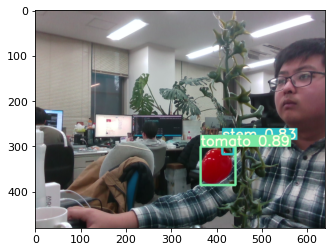

tensor([[365.21875, 300.84375, 442.28125, 385.15625,   0.88666,   1.00000],
        [413.12500, 285.01562, 438.87500, 317.48438,   0.83374,   0.00000]], device='cuda:0', grad_fn=<IndexBackward>) <pyrealsense2.frame Z16 #270139> [ 640x480  p[326.683 237.415]  f[619.191 619.425]  Inverse Brown Conrady [0 0 0 0 0] ]


In [ ]:
# One step

frames = pipeline.wait_for_frames()
aligned_frames = align.process(frames)
aligned_depth_frame = aligned_frames.get_depth_frame()
color_frame = aligned_frames.get_color_frame()
# 将帧转换为numpy数组
color_image = np.asanyarray(color_frame.get_data())
color_image = cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR)
depth_intrinsics = aligned_depth_frame.profile.as_video_stream_profile().intrinsics
device = torch.device('cuda:0')

img = torch.tensor(color_image)
img = np.transpose(img, (2, 0, 1))
half = device.type != 'cpu'  # half precision only supported on CUDA
img = img.half() if half else img.float()  # uint8 to fp16/32
img /= 255.0  # 0 - 255 to 0.0 - 1.0
if img.ndimension() == 3:
    img = img.unsqueeze(0)

img = img.to(device)
t1 = time_synchronized()
pred = model(img, augment=True)[0]

# Apply NMS
pred = non_max_suppression(pred, 0.81, 0.3, classes=None, agnostic=True)
t2 = time_synchronized()

# Process detections
img = np.array(img.squeeze(0).cpu())
img = np.transpose(img, (1, 2, 0))
img = img * 255
img = img.astype(np.uint8)
for i, det in enumerate(pred):  # detections per image
    # Print time (inference + NMS)
    print('Done. ({:.3f}s)'.format((t2 - t1)))    
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
if det is not None:
    for *xyxy, conf, cls in reversed(det):
        label = '%s %.2f' % (names[int(cls)], conf)
        print(xyxy)
        plot_one_box(xyxy, img, label=label, line_thickness=3)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
plt.show()

print(det,aligned_depth_frame,depth_intrinsics)

In [ ]:
det
res = calculate_frame_coor(det)
det
*xyxy, conf, cls = det[0]
xyxy = [int(x) for x in xyxy]
xyxy

[365, 300, 442, 385]

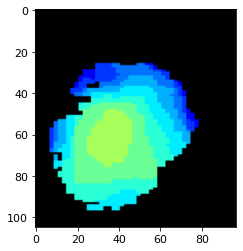

In [ ]:
padding = 10
depth_image = np.asanyarray(aligned_depth_frame.get_data())
obj_depth_image = depth_image[(xyxy[1]-padding):(xyxy[3]+padding),(xyxy[0]-padding):(xyxy[2]+padding)]
hist, bin_edges = np.histogram(obj_depth_image,120,range=(100,600))
min_val = bin_edges[np.argmax(hist)-2]
max_val = bin_edges[np.argmax(hist)+2]
mask = (obj_depth_image > min_val) & (obj_depth_image < max_val)

normalized = np.zeros_like(obj_depth_image, dtype=np.uint8)
normalized[mask] = np.clip(obj_depth_image[mask], min_val, max_val) - min_val

normalized = ((obj_depth_image / (max_val - min_val)) * 255).astype(np.uint8)
depth_colormap = cv2.applyColorMap(normalized, cv2.COLORMAP_JET)
depth_colormap[~mask] = [0, 0, 0]  # 将原始零值位置设为黑色
plt.imshow(depth_colormap)


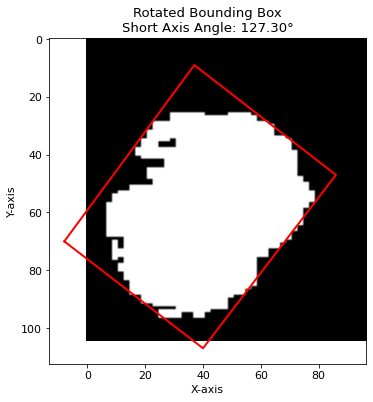

短轴的倾斜角：127.30°


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 找到 mask 中为 True 的坐标
y_coords, x_coords = np.where(mask)
points = np.column_stack((x_coords, y_coords))  # 转换为点集

# 计算旋转最小包围矩形
rect = cv2.minAreaRect(points.astype(np.float32))  # (center, (width, height), angle)
box = cv2.boxPoints(rect)  # 获取矩形顶点
box = np.int0(box)  # 转换为整数

# 提取矩形参数
(center_x, center_y), (width, height), angle = rect

# 短轴的倾斜角计算
if width < height:
    short_axis_angle = (angle + 90)  # 宽是短轴，直接取 angle
else:
    short_axis_angle = angle  # 高是短轴，角度加 90°

# 绘制原始图像和旋转矩形
plt.figure(figsize=(6, 6))
plt.imshow(mask, cmap="gray", origin="upper")  # 显示原始 mask
plt.plot(
    *np.append(box, [box[0]], axis=0).T,  # 确保闭合
    color="red",
    linewidth=2,
)  # 绘制旋转矩形
plt.title(f"Rotated Bounding Box\nShort Axis Angle: {short_axis_angle:.2f}°")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(False)
plt.show()

# 输出短轴的倾斜角
print(f"短轴的倾斜角：{short_axis_angle:.2f}°")


In [ ]:
import ikpy.chain
from Arm_Lib import Arm_Device
Arm = Arm_Device()
my_chain = ikpy.chain.Chain.from_urdf_file("/home/jetson/code/yolov5/yolov5-3.0/arm_real.URDF")
degree_list = [0,180,130,40,20,90,30]
servo_write(Arm,degree_list[1:],SERVO_SPEED,s_time = 1500)
angle_test = np.radians(degree_list)
transformations = my_chain.forward_kinematics(angle_test, full_kinematics=True)
for i in range(1, len(transformations)):  # 忽略起点（索引0）
    print(f"关节 {i} 的位置: {transformations[i][:3, 3]}")

In [ ]:
transformations = my_chain.forward_kinematics(angle_test, full_kinematics=True)
for i in range(1, len(transformations)):  # 忽略起点（索引0）
    print(f"关节 {i} 的位置: {transformations[i][:3, 3]}")
angle_test = np.radians([0,90,130,30,0,90,30])
print(transformations[-1][:3,3])
joint_list = list(my_chain.inverse_kinematics(transformations[-1][:3,3],initial_position=angle_test))

print(joint_list)
print([0,0,130,51,19,90,30])
print("solve",np.degrees(joint_list))
real_frame = my_chain.forward_kinematics(joint_list, full_kinematics=True)
for i in range(1, len(real_frame)):  # 忽略起点（索引0）
    print(f"关节 {i} 的位置: {real_frame[i][:3, 3]}")

In [ ]:
joint_list = list(my_chain.inverse_kinematics([-0.05,0,0.35],initial_position=angle_test))
print(np.degrees(joint_list))

In [ ]:
target_position = [-0.05,0,0.35]
grabber = 20
converted_position = np.array(target_position)
print("target coor:",converted_position)
joints = my_chain.inverse_kinematics(converted_position,initial_position = np.radians([0,90,130,20,40,90,30]))
joint_list = joints[1:-1]
print("servos should be",np.degrees(joint_list))
joint_deg_list = [int(x)for x in np.degrees(joint_list)]
joint_deg_list.append(grabber)
print("The angles of each joints should be:" , joint_deg_list)
real_frame = my_chain.forward_kinematics(joints)
error = np.abs(np.linalg.norm(list(real_frame[:3,3]),ord=2)-np.linalg.norm(converted_position,ord=2))
print("Error:{:.2f}%".format(error*100))
print("The position is:\n", real_frame)
if "{:.2f}%".format(error*100) != "0.00%":
    print("out of range")
else:
    servo_write(Arm,joint_deg_list,SERVO_SPEED)

model = detect()
names = ['stem','tomato']
det,aligned_depth_frame,depth_intrinsics = one_step(model,pipeline,names)